<a href="https://colab.research.google.com/github/jcdumlao14/Data-Science-Internship-Program-SKS/blob/main/Task_4_Churn_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 4: Churn Prediction Model**
## **Description:**
Choose suitable machine learning algorithms (e.g., logistic regression, decision trees) for churn prediction. Split data into training and testing sets, train and evaluate multiple models using metrics like accuracy, precision, recall, and F1-score. Perform feature selection and hyperparameter tuning for optimal performance.
## **Skills:**
- Machine learning algorithms
- Model training and evaluation,
- Feature selection,
- hyperparameter tuning
- Understanding of classification metrics


# **Import Libraries:**
 - `pandas`: For working with data in tables (like spreadsheets). It's used to load the data from the CSV file and manipulate it.
 - `matplotlib.pyplot`: For creating plots and charts to visualize the data or model results.
 - `numpy`: For numerical operations (like math).
 - `sklearn` (scikit-learn): The main machine learning library. It provides tools for:
    - Splitting data into training and testing sets (`train_test_split`).
    - Scaling numerical data (`StandardScaler`).
    - Converting categorical data into a numerical format that models can understand (`OneHotEncoder`).
    - Creating data processing pipelines (`Pipeline`).
    - Building machine learning models (Logistic Regression, Decision Tree, Random Forest).
    - Evaluating model performance (accuracy, precision, recall, F1-score).
    - Finding the best model settings (`GridSearchCV`).
    - Handling missing data (`SimpleImputer`).
    - `seaborn`: A library built on top of matplotlib that provides a higher-level interface for creating informative and aesthetically pleasing statistical graphics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer  # Import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

## Warnings
import warnings
warnings.filterwarnings('ignore')


# **Load the Data:**
- This line reads the data from a CSV file named "Telco_Customer_Churn_Dataset (3).csv" and stores it in a pandas DataFrame called df. A DataFrame is like a table.

In [2]:
# Load the dataset
df = pd.read_csv("Telco_Customer_Churn_Dataset  (3).csv")
df.head().style.background_gradient(cmap='Paired_r')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950000,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850000,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300000,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700000,151.65,Yes


# **Data Cleaning and Preprocessing:**
- `df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')`: This line tries to convert the 'TotalCharges' column to numbers. If it finds any values that can't be converted (e.g., text), it replaces them with `NaN` (Not a Number), which is pandas' way of representing missing data.
- `numerical_transformer`: Creates a pipeline to handle numerical features. It first fills in missing values (`NaNs`) using the `SimpleImputer` by replacing them with the mean of the column. Then, it scales the numerical features using `StandardScaler` so that each feature has a mean of 0 and a standard deviation of 1. This is important for many machine learning algorithms to perform well.
- Why Preprocessing? Machine learning models generally work best with numerical data. Also, features on different scales can cause problems, so scaling them helps. Missing data can also break models, so it needs to be handled.



In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Preprocessor with Imputation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [4]:
# Convert binary categorical features to numerical
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convert gender to numerical
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

- This converts columns that have "Yes" or "No" values into 1s and 0s. Machine learning models can't directly use text, so you need to convert categorical features like this into numerical representations. The same is done for 'gender'.


In [5]:
# Feature Engineering

def tenure_group(tenure):
    if tenure <= 12:
        return '0-12'
    elif tenure <= 24:
        return '12-24'
    elif tenure <= 48:
        return '24-48'
    elif tenure <= 60:
        return '48-60'
    else:
        return '60+'

df['tenure_group'] = df['tenure'].apply(tenure_group)


- This creates a new column called `tenure_group` based on the customer's tenure (how long they've been a customer). It groups customers into different tenure ranges. This is called feature engineering – creating new features from existing ones that might be more useful to the model.


# **Define Features (X) and Target (y):**
- `X`: The features (or independent variables) are the columns that the model will use to make predictions. Here, it's all columns in the DataFrame except 'customerID' and 'Churn'. 'customerID' is usually irrelevant for prediction, and 'Churn' is what we're trying to predict.

- `y`: The target variable (or dependent variable) is the column we're trying to predict. Here, it's the 'Churn' column, which indicates whether a customer churned or not.

In [6]:
# Define features (X) and target (y)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']


# **Identify Categorical and Numerical Features:**
- This identifies which columns in the `X` DataFrame are categorical (text-based) and which are numerical (numbers). This is important because categorical features need to be encoded (converted to numbers) before being used in most machine learning models.

In [7]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


# **Create Preprocessor:**
- This creates a `ColumnTransformer` that applies different preprocessing steps to different columns.

   - `('num', numerical_transformer, numerical_features)`: Applies the numerical_transformer (which we defined earlier for imputation and scaling) to the numerical features.
   - `('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)`: Applies `OneHotEncoder` to the categorical features. `OneHotEncoder` creates a new column for each unique value in a categorical column. For example, if you have a 'color' column with values 'red', 'green', and 'blue', OneHotEncoder will create three new columns: 'color_red', 'color_green', and 'color_blue'. If a customer's color is 'red', then 'color_red' will be 1, and the other two will be 0. `handle_unknown='ignore'` tells the encoder to ignore any unknown values that might appear in the test data but weren't present in the training data.
- *Why a ColumnTransformer?* This allows you to apply different preprocessing steps to different types of data within the same DataFrame. It keeps your code organized and makes it easier to manage complex preprocessing pipelines.

In [8]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# **Split Data into Training and Testing Sets:**
- This splits the data into two sets: a training set and a testing set.
  - `X_train, y_train`: Used to train the machine learning models. The model learns patterns from this data.
  - `X_test, y_test`: Used to evaluate how well the trained model performs on new, unseen data. This gives you an idea of how well the model will generalize to real-world data.
  - `test_size=0.2`: Specifies that 20% of the data should be used for testing, and 80% for training.
  - `random_state=42`: Sets a seed for the random number generator. This ensures that the data is split in the same way each time you run the code, making the results reproducible.
  - `stratify=y`: This is very important when you have an imbalanced dataset (where one class has significantly more examples than the other). `stratify=y` ensures that the training and testing sets have roughly the same proportion of each class (churned vs. not churned) as the original dataset. This helps prevent the model from being biased towards the majority class.

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  #stratify for balanced split


# **Model Building and Training (Logistic Regression, Decision Tree, Random Forest):**

- `Pipeline`: Creates a pipeline that chains together the preprocessing steps (`preprocessor`) and the model (`LogisticRegression`). This makes the code cleaner and easier to manage. When you call `fit()` on the pipeline, it automatically applies the preprocessing steps to the training data before training the model.
- `LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')`: Creates a Logistic Regression model. `solver='liblinear'` specifies the optimization algorithm to use (suitable for smaller datasets). `random_state=42` sets the seed for reproducibility. `class_weight='balanced'` is crucial for imbalanced datasets. It adjusts the weights of the classes during training, giving more weight to the minority class (churned customers) to prevent the model from being biased towards the majority class (non-churned customers).
- `param_grid_lr`: Defines a grid of hyperparameters to tune for the Logistic Regression model. Hyperparameters are settings that control the learning process (e.g., `C` is the regularization strength).
- `GridSearchCV`: Performs hyperparameter tuning using cross-validation. It tries out all the combinations of hyperparameters specified in `param_grid_lr` and evaluates the model's performance using cross-validation (`cv=5` means 5-fold cross-validation). It selects the hyperparameter combination that gives the best performance based on the chosen scoring metric. `scoring='f1'` means that it uses the F1-score to evaluate performance. The F1-score is a good metric to use when you have an imbalanced dataset.
- `grid_search_lr.fit(X_train, y_train)`: Trains the model using the training data and the hyperparameter tuning process.
- `best_model_lr = grid_search_lr.best_estimator_`: Gets the best model (the one with the best hyperparameters) from the `GridSearchCV` object.
- `y_pred_lr = best_model_lr.predict(X_test)`: Uses the trained model to make predictions on the testing data. These are the model's predictions for whether each customer in the test set will churn.

# Model Evaluation:
 - This calculates several metrics to evaluate the model's performance:
    - Accuracy: The proportion of predictions that were correct. (TP + TN) / (TP + TN + FP + FN)
    - Precision: Of all the customers the model predicted would churn, what proportion actually churned? TP / (TP + FP) (Avoids false positives.)
    - Recall: Of all the customers who actually churned, what proportion did the model correctly identify? TP / (TP + FN) (Avoids false negatives.)
    - F1-score: The harmonic mean of precision and recall. It gives a balanced measure of the model's performance. It's often a good metric to use when you have an imbalanced dataset.
    - These metrics are calculated for each model (Logistic Regression, Decision Tree, Random Forest).
 - The results are printed to the console.

In [10]:
# --- Model 1: Logistic Regression ---
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])  # Added class_weight

param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='f1') # changed scoring to f1
grid_search_lr.fit(X_train, y_train)

best_model_lr = grid_search_lr.best_estimator_
y_pred_lr = best_model_lr.predict(X_test)

# Calculate metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Results:")
print(f"Best Parameters: {grid_search_lr.best_params_}")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print("-" * 30)



# --- Model 2: Decision Tree ---
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))]) #Added class_weight

param_grid_dt = {
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5]
}

grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='f1') # changed scoring to f1
grid_search_dt.fit(X_train, y_train)

best_model_dt = grid_search_dt.best_estimator_
y_pred_dt = best_model_dt.predict(X_test)

# Calculate metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print("Decision Tree Results:")
print(f"Best Parameters: {grid_search_dt.best_params_}")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-score: {f1_dt:.4f}")
print("-" * 30)


# --- Model 3: Random Forest ---
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))]) # Added class_weight

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1')  # changed scoring to f1
grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print("-" * 30)



Logistic Regression Results:
Best Parameters: {'classifier__C': 0.01}
Accuracy: 0.7360
Precision: 0.5017
Recall: 0.7754
F1-score: 0.6092
------------------------------
Decision Tree Results:
Best Parameters: {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy: 0.7459
Precision: 0.5140
Recall: 0.7834
F1-score: 0.6208
------------------------------
Random Forest Results:
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Accuracy: 0.7608
Precision: 0.5362
Recall: 0.7326
F1-score: 0.6192
------------------------------


# **Feature Importance (Random Forest):**
  - This section tries to extract and display the feature importances from the Random Forest model. Feature importances tell you which features were most important in making predictions.
  - It gets the feature importances from the trained Random Forest model (`best_model_rf.named_steps['classifier'].feature_importances_`).
  - It creates a DataFrame to display the feature importances in a table.
  - It plots the feature importances in a bar chart.



Feature Importances (Random Forest):
                                    Feature  Importance
4                                    tenure    0.113326
14                             TotalCharges    0.098731
13                           MonthlyCharges    0.087882
21                  Contract_Month-to-month    0.078083
9                               TechSupport    0.077480
6                            OnlineSecurity    0.075700
23                        Contract_Two year    0.070087
28                        tenure_group_0-12    0.045050
26           PaymentMethod_Electronic check    0.040132
19              InternetService_Fiber optic    0.037319
7                              OnlineBackup    0.023953
22                        Contract_One year    0.021399
12                         PaperlessBilling    0.019919
18                      InternetService_DSL    0.019176
8                          DeviceProtection    0.016993
20                       InternetService_No    0.015733
0         

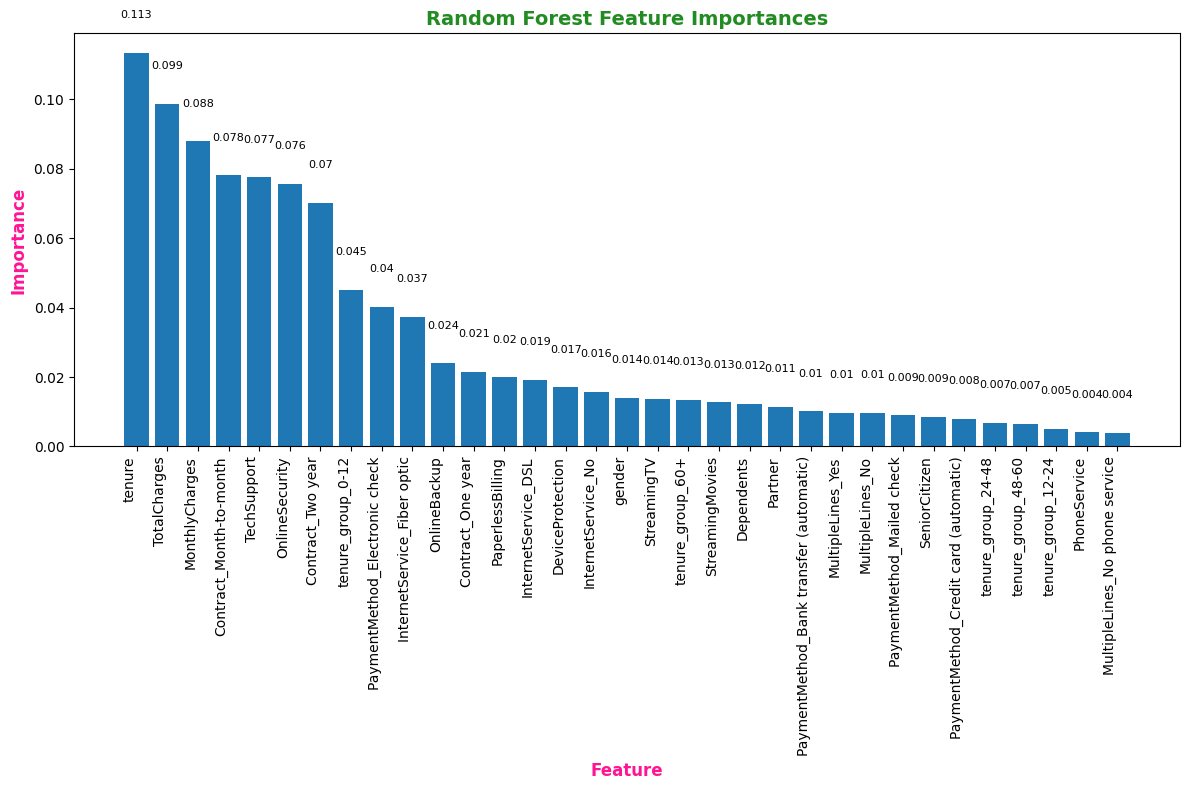

In [11]:
# Feature Importance (Example with Random Forest)

try:
    if hasattr(best_model_rf.named_steps['classifier'], 'feature_importances_'):
        feature_importances = best_model_rf.named_steps['classifier'].feature_importances_

        # Get numerical feature names *before* scaling:
        numerical_feature_names = numerical_features.tolist()

        # Get one-hot encoded categorical feature names:
        categorical_feature_names = best_model_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out().tolist()

        # Combine numerical and categorical feature names
        feature_names = numerical_feature_names + categorical_feature_names

        # Create a dataframe to display feature importances
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
        print("\nFeature Importances (Random Forest):")
        print(feature_importance_df)


        # Plotting Feature Importances
        plt.figure(figsize=(12, 8))
        plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
        plt.xlabel('Feature',fontsize=12,fontweight = 'bold', color = 'deeppink')
        plt.ylabel('Importance',fontsize=12,fontweight = 'bold', color = 'deeppink')
        plt.title('Random Forest Feature Importances', fontsize=14, fontweight = 'bold', color = 'forestgreen')
        plt.xticks(rotation=90, ha='right', fontsize=10)  # Rotate x-axis labels for readability
        plt.tight_layout()

        # Annotate the bars with their values
        for i, v in enumerate(feature_importance_df['Importance']):
            plt.text(i, v + 0.01, str(round(v, 3)), ha='center', fontsize=8)

        plt.show()


except Exception as e:
    print(f"Could not display feature importances: {e}")


# **Plotting Model Results:**
  - This section creates a bar chart to compare the performance of the three models (Logistic Regression, Decision Tree, and Random Forest) based on accuracy, precision, recall, and F1-score. It's a visual way to see which model performed best.

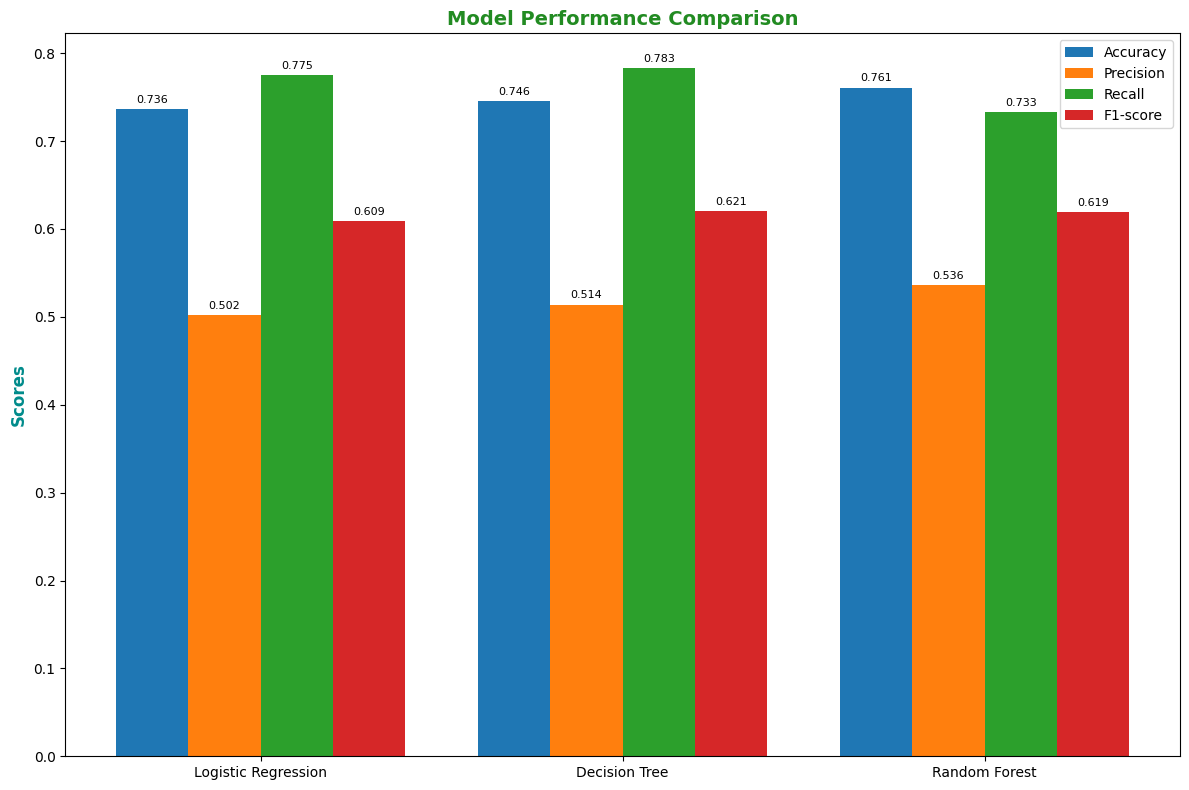

In [12]:
# --- Plotting Model Results ---
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_rf]
precision_scores = [precision_lr, precision_dt, precision_rf]
recall_scores = [recall_lr, recall_dt, recall_rf]
f1_scores = [f1_lr, f1_dt, f1_rf]

x = np.arange(len(model_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - 3*width/2, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precision_scores, width, label='Precision')
rects3 = ax.bar(x + width/2, recall_scores, width, label='Recall')
rects4 = ax.bar(x + 3*width/2, f1_scores, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize=12,fontweight = 'bold', color = 'darkcyan')
ax.set_title('Model Performance Comparison',fontsize=14,fontweight = 'bold', color = 'forestgreen')
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=10)
ax.legend(fontsize=10)

# Function to add labels above the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()

# Understanding the Metrics



In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Telco_Customer_Churn_Dataset  (3).csv")

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Fill NaN values in TotalCharges with 0 or another appropriate value like mean
df['TotalCharges'] = df['TotalCharges'].fillna(0)

binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    if col in df.columns: #check if the column exists before processing
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convert gender to numerical
if 'gender' in df.columns:
     df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})


X = df[['tenure', 'MonthlyCharges']]
y = df['Churn'].map({'Yes': 1, 'No': 0}) if 'Churn' in df.columns else None

if y is None:
    raise KeyError("Churn column not found in the dataset.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Model (Logistic Regression for example)
model = LogisticRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# --- Calculate and Print Classification Metrics ---

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# 3. Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# 4. F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7885
Precision: 0.6616
Recall: 0.4530
F1-Score: 0.5377


- Accuracy: Overall, how often is the classifier correct?  (TP + TN) / (TP + TN + FP + FN)
  - High accuracy is desirable, but can be misleading if classes are imbalanced.
- Precision: When the classifier predicts the positive class, how often is it correct? TP / (TP + FP)
  - High precision means the classifier is good at not labeling negative samples as positive (low false positive rate).
  - Useful when the cost of a false positive is high (e.g., spam detection: you don't want to incorrectly classify important emails as spam).

- Recall:  Of all the actual positive examples, how many did the classifier correctly identify? TP / (TP + FN)
  - High recall means the classifier is good at finding most of the positive samples (low false negative rate).
  - Useful when the cost of a false negative is high (e.g., disease detection: you don't want to miss any actual cases).

- F1-Score:  The harmonic mean of precision and recall, balancing both concerns.  2 * (Precision * Recall) / (Precision + Recall)
  - Provides a single score that considers both precision and recall.
  - Useful when you want to balance precision and recall, especially when classes are imbalanced.


# **Confusion Matrix**


Confusion Matrix:
[[1406  133]
 [ 314  260]]


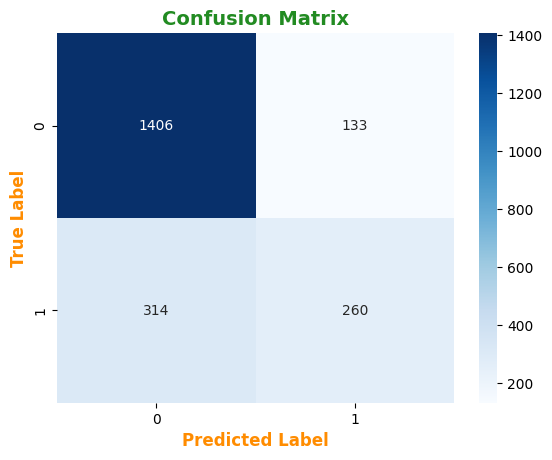

In [14]:
# --- Confusion Matrix ---

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# --- Visualizing the Confusion Matrix  ---
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")  # annot=True displays the values; fmt="d" formats as integers
plt.title("Confusion Matrix",fontsize=14,fontweight = 'bold', color = 'forestgreen')
plt.xlabel("Predicted Label",fontsize = 12, fontweight = 'bold', color = 'darkorange')
plt.ylabel("True Label",fontsize = 12, fontweight = 'bold', color = 'darkorange')
plt.show()

# **Interpretation of Confusion Matrix**

## In the confusion matrix:
 - The rows represent the actual classes.
 - The columns represent the predicted classes.

## For a binary classification problem (positive=1, negative=0):
 - TN (True Negative):  Number of negative examples correctly classified as negative.  cm[0, 0]
 - FP (False Positive): Number of negative examples incorrectly classified as positive.  cm[0, 1]  (Type I error)
 - FN (False Negative): Number of positive examples incorrectly classified as negative.  cm[1, 0]  (Type II error)
 - TP (True Positive):  Number of positive examples correctly classified as positive.  cm[1, 1]

## From the confusion matrix, you can calculate:
 - Precision = TP / (TP + FP)
 - Recall    = TP / (TP + FN)